In [309]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

In [310]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline

In [311]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [312]:
query_dir = 'queries'

In [313]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [314]:
query_client = bigquery.Client()

In [315]:
request = queries['combined_analysis_data.sql']

In [316]:
data = query_client.query(request).to_dataframe()

In [317]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [318]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602 entries, 0 to 1858
Data columns (total 18 columns):
ad_id                1602 non-null int64
apt_id               855 non-null object
new_building         1602 non-null bool
num_bedrooms         1580 non-null float64
floor                1273 non-null float64
primary_size         1602 non-null float64
total_size           1546 non-null float64
price                1602 non-null float64
property_type        1602 non-null object
ownership_type       1602 non-null object
construction_year    1601 non-null float64
energy_character     753 non-null object
common_expenses      561 non-null float64
common_wealth        418 non-null float64
common_debt          536 non-null float64
time_s               1600 non-null float64
short_description    1602 non-null object
full_description     1602 non-null object
dtypes: bool(1), float64(10), int64(1), object(6)
memory usage: 226.8+ KB


In [319]:
data.head()

,ad_id,apt_id,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,common_wealth,common_debt,time_s,short_description,full_description
0,85287718,120,True,2.0,1.0,48.0,59.0,4150000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,905.0,Hovinenga Hus C ...,Ansvarlig megler...
1,85287718,143,True,2.0,2.0,56.0,61.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,905.0,Hovinenga Hus C ...,Ansvarlig megler...
2,85287718,183,True,2.0,5.0,51.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,905.0,Hovinenga Hus C ...,Ansvarlig megler...
3,85287718,187,True,2.0,5.0,48.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,905.0,Hovinenga Hus C ...,Ansvarlig megler...
4,85287718,204,True,3.0,6.0,86.0,92.0,8495000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,905.0,Hovinenga Hus C ...,Ansvarlig megler...


In [320]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

In [321]:
num_cols = ['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms', 'floor', 'construction_year']
cat_cols = ['new_building', 'energy_letter', 'energy_color', 'property_type', 'ownership_type']
text_cols = ['short_description', 'full_description']

In [322]:
num_data = data[num_cols].copy()

In [323]:
cat_data = data[cat_cols].copy()

In [324]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [325]:
text_data = data[text_cols].copy()

In [326]:
# target = num_data.price / num_data.primary_size

In [327]:
num_data['price_per_sq_m'] = num_data.price / num_data.primary_size

In [328]:
num_cat_data_corr = num_data.join(cat_data).corr()

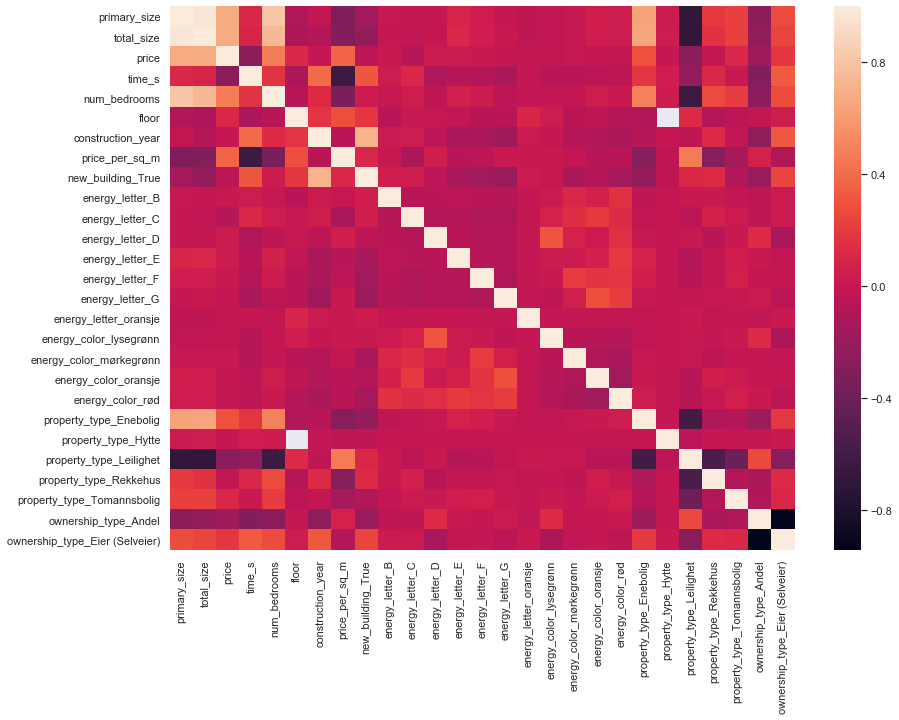

In [329]:
sns.heatmap(num_cat_data_corr)

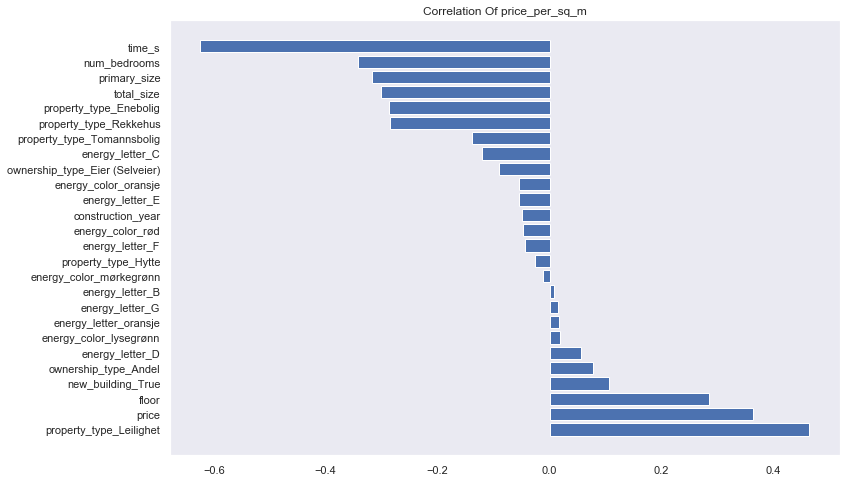

In [330]:
corr_col = 'price_per_sq_m'
to_plot = num_cat_data_corr[corr_col].drop(corr_col).sort_values(ascending=False)
f = plt.figure(figsize=(12, 8))
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title(f'Correlation Of {corr_col}')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [462]:
model_data = num_data.join(cat_data)

In [463]:
model_data.dropna(inplace=True)

In [464]:
model_data.describe()

,primary_size,total_size,price,time_s,num_bedrooms,floor,construction_year,price_per_sq_m,new_building_True,energy_letter_B,energy_letter_C,energy_letter_D,energy_letter_E,energy_letter_F,energy_letter_G,energy_letter_oransje,energy_color_lysegrønn,energy_color_mørkegrønn,energy_color_oransje,energy_color_rød,property_type_Enebolig,property_type_Hytte,property_type_Leilighet,property_type_Rekkehus,property_type_Tomannsbolig,ownership_type_Andel,ownership_type_Eier (Selveier)
count,1221.000000,1221.000000,1.221000e+03,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.0,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000
mean,79.688780,87.265274,5.507196e+06,1398.235872,2.244881,3.294021,1996.523342,71754.176945,0.602785,0.044226,0.084357,0.056511,0.040131,0.074529,0.089271,0.001638,0.029484,0.069615,0.117117,0.146601,0.031122,0.0,0.910729,0.035217,0.022113,0.257985,0.721540
std,35.722355,43.288738,2.791692e+06,823.607322,0.891573,1.928528,36.911420,22710.192387,0.489522,0.205681,0.278036,0.231001,0.196347,0.262738,0.285251,0.040456,0.169228,0.254601,0.321692,0.353853,0.173719,0.0,0.285251,0.184403,0.147111,0.437705,0.448425
min,14.000000,16.000000,1.514691e+06,207.000000,0.000000,1.000000,1850.000000,17347.783784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.000000,62.000000,3.615219e+06,781.000000,2.000000,2.000000,1978.000000,57142.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
50%,73.000000,79.000000,4.757800e+06,1187.000000,2.000000,3.000000,2019.000000,69499.151515,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000
75%,91.000000,97.100000,6.516142e+06,1968.000000,3.000000,4.000000,2019.000000,85568.115942,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,368.000000,479.000000,2.310457e+07,3849.000000,8.000000,12.000000,2019.000000,161164.967742,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [465]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1221 entries, 0 to 1858
Data columns (total 27 columns):
primary_size                      1221 non-null float64
total_size                        1221 non-null float64
price                             1221 non-null float64
time_s                            1221 non-null float64
num_bedrooms                      1221 non-null float64
floor                             1221 non-null float64
construction_year                 1221 non-null float64
price_per_sq_m                    1221 non-null float64
new_building_True                 1221 non-null uint8
energy_letter_B                   1221 non-null uint8
energy_letter_C                   1221 non-null uint8
energy_letter_D                   1221 non-null uint8
energy_letter_E                   1221 non-null uint8
energy_letter_F                   1221 non-null uint8
energy_letter_G                   1221 non-null uint8
energy_letter_oransje             1221 non-null uint8
energy_color_

In [466]:
model_data.columns

Index(['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms',
       'floor', 'construction_year', 'price_per_sq_m', 'new_building_True',
       'energy_letter_B', 'energy_letter_C', 'energy_letter_D',
       'energy_letter_E', 'energy_letter_F', 'energy_letter_G',
       'energy_letter_oransje', 'energy_color_lysegrønn',
       'energy_color_mørkegrønn', 'energy_color_oransje', 'energy_color_rød',
       'property_type_Enebolig', 'property_type_Hytte',
       'property_type_Leilighet', 'property_type_Rekkehus',
       'property_type_Tomannsbolig', 'ownership_type_Andel',
       'ownership_type_Eier (Selveier)'],
      dtype='object')

In [467]:
target = 'price'

In [468]:
X = model_data.drop(['price_per_sq_m', 'total_size', 'price'], axis=1)
y = model_data[[target]].rename(columns={target: 'target'})

In [469]:
random_seed = 42
test_size = 0.25

In [470]:
selected_cols = ['primary_size', 'time_s', 'num_bedrooms',
                 'floor', 'construction_year', 'new_building_True',
                 'property_type_Enebolig', 'property_type_Leilighet',
                 'property_type_Rekkehus', 'property_type_Tomannsbolig']

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_cols], y, test_size=test_size, random_state=random_seed)

In [472]:
X_train.shape

(915, 10)

In [473]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [474]:
steps = []
steps.append(('standardize', StandardScaler()))
steps.append(('dl', KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False)))
# steps.append(('ada', AdaBoostRegressor()))

In [475]:
pipeline = Pipeline(steps)

In [476]:
scaler_y = StandardScaler().fit(y_train)

In [477]:
pipeline.fit(X_train, scaler_y.transform(y_train).ravel())

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dl',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x14ae4bfd0>)],
         verbose=False)

In [478]:
pred = scaler_y.inverse_transform(pipeline.predict(X_test))

In [479]:
y_pred = pd.DataFrame(pred, index=X_test.index, columns=['predicted'])

In [480]:
print(f'The mae is: {mean_absolute_error(y_test, y_pred):.5f}')

The mae is: 959725.86193


In [481]:
res = y_pred.join(y_test)

In [482]:
res.head().style.format('{:.4f}')

,predicted,target
726,3792639.7500,3658788.0000
308,3840688.2500,3595000.0000
44,9421062.0000,15890120.0000
1465,6029424.0000,6158357.0000
1045,5561067.5000,4839722.0000


In [483]:
res['pred_target_diff'] = res['predicted'] - res['target']

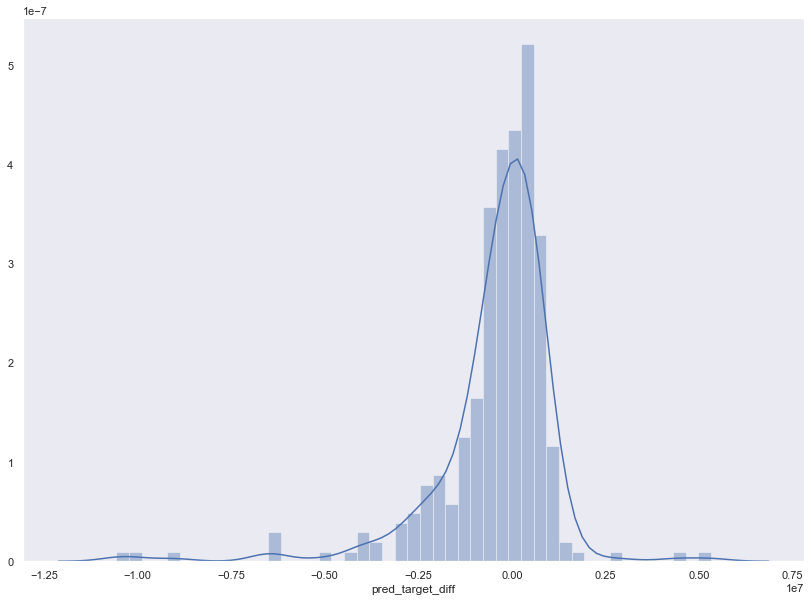

In [484]:
sns.distplot(res.pred_target_diff)